In [35]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer, Normalizer
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
# Create linear regression object
regr_mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(20), random_state=1, max_iter=500, alpha=0.01)#
regr = linear_model.LinearRegression()
df = pd.read_csv('melb_data.csv')
def label(column, raw=False):
    lbl = LabelBinarizer()
    if raw:
        lbl.fit(column)
        return lbl
    return pd.DataFrame(lbl.fit_transform(column), columns=lbl.classes_)
today = dt.now().date().toordinal() 
Date = pd.Series([today - dt.strptime(i, "%d/%m/%Y").date().toordinal() for i in df.Date])
Data = np.log(Date)
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [3]:
df.Postcode

0        3067.0
1        3067.0
2        3067.0
3        3067.0
4        3067.0
          ...  
13575    3150.0
13576    3016.0
13577    3016.0
13578    3016.0
13579    3013.0
Name: Postcode, Length: 13580, dtype: float64

In [4]:
def outlier(column, m=1, plot = True):
    Y = df.Price
    setattr(Y,'name','Price')
    #return Y.name
    m = 0.9
    ind = []
    #return dir(Y)
    X = pd.concat([column,Y], axis='columns')
    X.dropna(inplace=True)
    Y = np.log(X[[Y.name]])
    X.drop(['Price'], axis='columns', inplace=True)
    regr.fit(X, Y)
    data = regr.coef_
    y=  data * [abs(data - np.mean(data)) > m * np.std(data)]
    if type(y[0]) == type(y):
        y = y[0][0]
    y = [ ind.append(i) or a if a else None for i, a in enumerate(y) ]
    if plot:
        plt.scatter(X.columns.map(str),y)
        plt.xticks(())
    return X.columns[ind]

Kaye            0.008581
Keatings        0.008581
Bullengarook    0.008581
Emerald         0.008581
dtype: float64

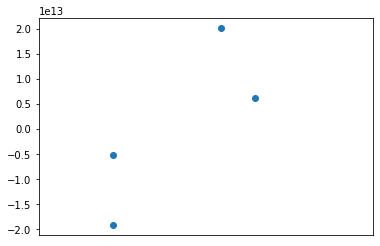

In [5]:
# df.Date = datter.fit_transform(df.Date)
types = label(df.Type)
method=label(df.Method)
suburb = label(df.Suburb)
df.Regionname.unique()
region = 1 * pd.DataFrame([('North' in i, 'West' in i, 'Metropolitan' in i) for i in df.Regionname], columns=['Northern', 'Western', 'Metropolitan'])
sellerG = label(df.SellerG)
seller = sellerG[outlier(sellerG, plot=False)]
suburbE = suburb[outlier(suburb, 6, plot = False)]

df.loc[:,('CouncilArea')] = df.CouncilArea.fillna('Unavailable')
c_area = label(df.CouncilArea)
post = label(df.Postcode)
postE = post[outlier(post, plot=False)]
all_sparse = pd.concat([sellerG, suburb], axis=1)
all_sparseE = all_sparse[outlier(all_sparse, m = 1e-12)]
all_sparseE.std()

/srv/paws/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean squared error: 361.38
Coefficient of determination: -1219.36


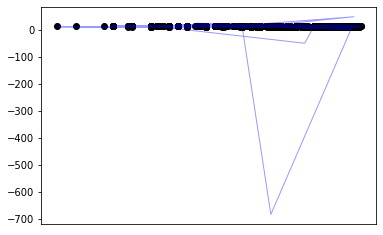

(6830, 256)

In [41]:
from sklearn.model_selection import train_test_split
X = pd.concat([df[
            ['Distance', 'Rooms', 'Car', 'Price', 'YearBuilt', 'Longtitude', 'Lattitude', 'Landsize',
            'BuildingArea', 'Propertycount', 'Bedroom2', 'Bathroom']],
                Date, types, method, c_area, post, region
              ], axis='columns')
X.Longtitude -= X.Longtitude.mean() 
X.Lattitude -= X.Lattitude.mean() 
X.YearBuilt = np.log(X.YearBuilt)
X.Bedroom2 **=2
X.loc[:, ('Car')] = np.exp(X.loc[:, ('Car')])
X.loc[:, ('Rooms_2')] = X.loc[:, ('Rooms')]**2
X.loc[:,('Distance_2')] = X.loc[:,('Distance')]**2
X.dropna( inplace=True)
Y = np.log(X.Price)
X.drop(columns=['Price'], axis='columns',inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


# Train the model using the training sets
res = regr_mlp.fit(X_train, Y_train)

# Make predictions using the testing set
diabetes_y_pred = regr_mlp.predict(X_test)

# The coefficients
#print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y_test, diabetes_y_pred))

# Plot outputs
x = X_test.YearBuilt
plt.scatter(x, Y_test,  color='black')
plt.plot(x, diabetes_y_pred, color=[0,0,1, 0.4], linewidth=1)
#plt.scatter(X.columns.map(str), regr.coef_)
plt.xticks(())
#plt.yticks(())

plt.show()
X.shape

In [ ]:
cols = X.columns[10:20]
plt.scatter(range(len(cols)), X[cols].abs().max())
X[cols].abs().max()

In [46]:
res.score(X_test, Y_test)

-1219.3585149110402